# MOVIE STUDIO ANALYSIS

<img src="images/moviedog.jpg" style="width:100%; height:auto;">

## Business understanding

Our company have decided to create a new movie studio, but they don’t know anything about creating movies. We have been charged with exploring what types of films are currently doing the best at the box office.
We must then translate the findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

* Our focus will be to make suggestions for the type of movies that will be the most profitable for our new movie division.

## Data understanding

we will be using the following datasets:
1. `rt.reviews.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
2. `rt.movie_info.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
3. `im.db` from [IMDB](https://www.imdb.com/)
4. `bom.movie_gross.csv` from [BOXOFFICE MOJO](https://www.boxofficemojo.com/)
5. `tn.movie_budgets.csv` from [NUMBERS](https://www.the-numbers.com/)

### Importing libraries

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

### Loading Data sets

In [2]:
# loading datasets

# reviews dataset
file_path = 'data/rt.reviews.tsv'

try:
    review_df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f"Error parsing file: {e}")

#Loading Movie_Info
movie_info_df = pd.read_csv('data/rt.movie_info.tsv', sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')

f'''
# bom.movie_gross.csv
path = 'data/bom.movie_gross.csv'
movie_gross_df = pd.read_csv(path)
'''

# im.dbsqlite, we load only the 2 tables that are needed for the analysis. 
conn = sqlite3.connect('data/im.db')
q = '''
SELECT *
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_ID = movie_ratings.movie_id
'''
imdb_df = pd.read_sql(q, conn)

# Loading 'The Numbers' Dataset
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)


## Data understanding

### 1. review_df

## DATA CLEANING

#### 1.1. Merging review_df and Movie_info_df

In [3]:
#merge the two dfs
merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')

#### 1.2 Dropping columns not used

In [4]:
# columns to drop
columns_to_drop =['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio']

merged_df = merged_df.drop(columns_to_drop, axis=1)

#### 1.3 Changing column names for rating_x (star_rating) and rating_y(MPAA_rating)

In [5]:
merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'}, inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,currency,box_office,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes


#### 1.4 checking and Dealing with missing values

In [6]:
merged_df.isna().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
currency        21122
box_office      21122
runtime           838
dtype: int64

#### 1.5 Standardizing star_rating

In [7]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
# merged_df

#### 1.5.1 fill missing standardized rating with mean

In [ ]:
# fill standardized_rating with mean

merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)

In [18]:
# drop rows with missing values on columns `MPAA_rating` and `genre`
merged_df = merged_df.dropna(subset=['MPAA_rating', 'genre'])

In [22]:
# Drop the star_rating column

merged_df = merged_df.drop('star_rating', axis=1)

In [25]:
merged_df.isna().sum()

id                         0
fresh                      0
date                       0
MPAA_rating                0
genre                      0
director                5354
theater_date            1139
dvd_date                1139
currency               21035
box_office             21035
runtime                  752
standardized_rating        0
dtype: int64

#### 1.1 using `.info` to understand the dataset

In [9]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [10]:
# checking null values
review_df.isna().sum()

review_df['top_critic']

0        0
1        0
2        0
3        0
4        0
        ..
54427    1
54428    0
54429    0
54430    0
54431    0
Name: top_critic, Length: 54432, dtype: int64

## Visualizing datasets

In [11]:
# cleaning currency strings
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

# Clean and convert monetary columns to numeric
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency).astype(float)



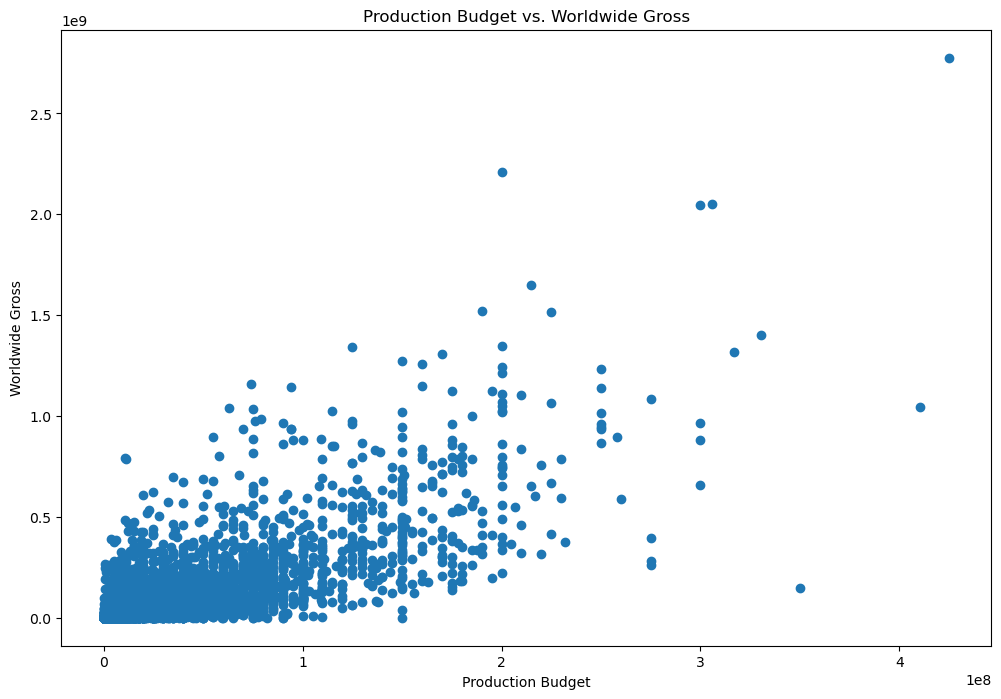

In [12]:
# visualize gross revenue vs budget using a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(movie_budgets_df['production_budget'], movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()